<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S9/EVA4_S9_Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Initialization

Import required modules

In [1]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-03-21 12:11:55.033248


In [0]:
# !pip install albumentations==0.4.5

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from data.data_engine import DataEngine
from config import ModelConfig
from models.QuizDNN import QuizDNN
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam

## Model Configuration and Set Seed

View model configuration and set the seed

In [3]:
# View model config
args = ModelConfig()
args.print_config()

"""
Image Augmentation args:
---------------
HueSaturationValue(p=0.25),
HorizontalFlip(p=0.25),
Rotate(limit=5, p=0.25),
CoarseDropout(max_holes=1, max_height=16, max_width=16, min_height=4,
      min_width=4, fill_value=mean*255.0, p=0.25),
"""

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 35,
  'l1_decay': 2e-05,
  'l2_decay': 0.002,
  'lr': 0.1,
  'max_lr': 0.05,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


## Data Loading and Visualization

Preprocess and load the cifar10 dataset. Visualise the dataset.

Files already downloaded and verified
Files already downloaded and verified
plane   dog  deer  deer


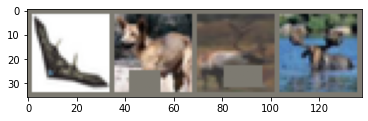

In [4]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

## Model

Create model and display model summary

In [5]:
device = which_device()
net = QuizDNN(args)
model = net.to(device)
show_model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
             ReLU-14           [-1, 64,

## Training and Testing

Train the model and evaluate it

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=args.max_lr, epochs=args.epochs,
                       steps_per_epoch=len(data.train_loader))

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=117.33990478515625 L1_loss=6802.845703125 Loss=1.7351722717285156 Batch_id=781 Accuracy=45.85: 100%|██████████| 782/782 [00:25<00:00, 30.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0189, Accuracy: 5731/10000 (57.31%)

EPOCH: 2


L2_loss=120.04926300048828 L1_loss=6895.087890625 Loss=1.3162248134613037 Batch_id=781 Accuracy=61.58: 100%|██████████| 782/782 [00:25<00:00, 30.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0170, Accuracy: 6131/10000 (61.31%)

EPOCH: 3


L2_loss=124.76177978515625 L1_loss=7381.6455078125 Loss=1.25835120677948 Batch_id=781 Accuracy=68.12: 100%|██████████| 782/782 [00:25<00:00, 30.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0127, Accuracy: 7233/10000 (72.33%)

EPOCH: 4


L2_loss=129.94454956054688 L1_loss=8143.26513671875 Loss=1.2419664859771729 Batch_id=781 Accuracy=72.26: 100%|██████████| 782/782 [00:25<00:00, 30.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0118, Accuracy: 7407/10000 (74.07%)

EPOCH: 5


L2_loss=134.82936096191406 L1_loss=8971.8642578125 Loss=1.0075044631958008 Batch_id=781 Accuracy=75.37: 100%|██████████| 782/782 [00:25<00:00, 30.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0110, Accuracy: 7569/10000 (75.69%)

EPOCH: 6


L2_loss=138.3097686767578 L1_loss=9684.8564453125 Loss=1.3074902296066284 Batch_id=781 Accuracy=77.12: 100%|██████████| 782/782 [00:25<00:00, 30.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 7765/10000 (77.65%)

EPOCH: 7


L2_loss=140.17904663085938 L1_loss=10262.078125 Loss=2.169022798538208 Batch_id=781 Accuracy=78.54: 100%|██████████| 782/782 [00:25<00:00, 30.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 7982/10000 (79.82%)

EPOCH: 8


L2_loss=141.985595703125 L1_loss=10794.68359375 Loss=1.4794366359710693 Batch_id=781 Accuracy=79.34: 100%|██████████| 782/782 [00:25<00:00, 30.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 7956/10000 (79.56%)

EPOCH: 9


L2_loss=142.74993896484375 L1_loss=11228.583984375 Loss=1.0442825555801392 Batch_id=781 Accuracy=80.45: 100%|██████████| 782/782 [00:25<00:00, 30.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8163/10000 (81.63%)

EPOCH: 10


L2_loss=142.77804565429688 L1_loss=11522.720703125 Loss=0.9556236267089844 Batch_id=781 Accuracy=81.31: 100%|██████████| 782/782 [00:25<00:00, 30.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8241/10000 (82.41%)

EPOCH: 11


L2_loss=142.90139770507812 L1_loss=11805.2890625 Loss=1.3633402585983276 Batch_id=781 Accuracy=81.78: 100%|██████████| 782/782 [00:25<00:00, 30.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0085, Accuracy: 8190/10000 (81.90%)

EPOCH: 12


L2_loss=142.72158813476562 L1_loss=11962.2255859375 Loss=1.0056533813476562 Batch_id=781 Accuracy=82.39: 100%|██████████| 782/782 [00:26<00:00, 30.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8212/10000 (82.12%)

EPOCH: 13


L2_loss=142.48922729492188 L1_loss=12118.4375 Loss=1.6200765371322632 Batch_id=781 Accuracy=82.87: 100%|██████████| 782/782 [00:25<00:00, 30.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0079, Accuracy: 8299/10000 (82.99%)

EPOCH: 14


L2_loss=142.97027587890625 L1_loss=12261.04296875 Loss=0.8671578168869019 Batch_id=781 Accuracy=83.24: 100%|██████████| 782/782 [00:26<00:00, 30.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8328/10000 (83.28%)

EPOCH: 15


L2_loss=142.84234619140625 L1_loss=12321.6923828125 Loss=0.8424665331840515 Batch_id=781 Accuracy=83.60: 100%|██████████| 782/782 [00:25<00:00, 30.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8465/10000 (84.65%)

EPOCH: 16


L2_loss=143.66656494140625 L1_loss=12408.7158203125 Loss=0.8844523429870605 Batch_id=781 Accuracy=83.62: 100%|██████████| 782/782 [00:25<00:00, 30.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0079, Accuracy: 8347/10000 (83.47%)

EPOCH: 17


L2_loss=144.015625 L1_loss=12442.220703125 Loss=1.200919270515442 Batch_id=781 Accuracy=84.02: 100%|██████████| 782/782 [00:25<00:00, 30.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8363/10000 (83.63%)

EPOCH: 18


L2_loss=144.15489196777344 L1_loss=12455.7138671875 Loss=1.312065601348877 Batch_id=781 Accuracy=84.44: 100%|██████████| 782/782 [00:25<00:00, 30.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8392/10000 (83.92%)

EPOCH: 19


L2_loss=144.11561584472656 L1_loss=12457.5234375 Loss=0.6551082134246826 Batch_id=781 Accuracy=84.68: 100%|██████████| 782/782 [00:25<00:00, 30.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 100 %
Accuracy of  bird : 88 %
Accuracy of   cat : 79 %
Accuracy of  deer : 88 %
Accuracy of   dog : 68 %
Accuracy of  frog : 81 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0069, Accuracy: 8538/10000 (85.38%)

EPOCH: 20


L2_loss=144.29910278320312 L1_loss=12420.2880859375 Loss=1.0949848890304565 Batch_id=781 Accuracy=84.73: 100%|██████████| 782/782 [00:25<00:00, 30.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8451/10000 (84.51%)

EPOCH: 21


L2_loss=143.91525268554688 L1_loss=12361.0654296875 Loss=1.177581787109375 Batch_id=781 Accuracy=85.34: 100%|██████████| 782/782 [00:25<00:00, 30.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8288/10000 (82.88%)

EPOCH: 22


L2_loss=143.4805145263672 L1_loss=12288.8232421875 Loss=1.4638253450393677 Batch_id=781 Accuracy=85.78: 100%|██████████| 782/782 [00:25<00:00, 30.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8411/10000 (84.11%)

EPOCH: 23


L2_loss=142.85150146484375 L1_loss=12222.5751953125 Loss=1.3024930953979492 Batch_id=781 Accuracy=86.19: 100%|██████████| 782/782 [00:25<00:00, 30.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 93 %
Accuracy of  bird : 80 %
Accuracy of   cat : 80 %
Accuracy of  deer : 85 %
Accuracy of   dog : 68 %
Accuracy of  frog : 87 %
Accuracy of horse : 92 %
Accuracy of  ship : 90 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0068, Accuracy: 8568/10000 (85.68%)

EPOCH: 24


L2_loss=142.35719299316406 L1_loss=12116.3984375 Loss=1.4108657836914062 Batch_id=781 Accuracy=86.57: 100%|██████████| 782/782 [00:25<00:00, 30.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 98 %
Accuracy of  bird : 83 %
Accuracy of   cat : 70 %
Accuracy of  deer : 78 %
Accuracy of   dog : 75 %
Accuracy of  frog : 86 %
Accuracy of horse : 73 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0068, Accuracy: 8529/10000 (85.29%)

EPOCH: 25


L2_loss=141.37794494628906 L1_loss=11996.5732421875 Loss=0.6413270235061646 Batch_id=781 Accuracy=87.06: 100%|██████████| 782/782 [00:25<00:00, 30.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 84 %
Accuracy of   car : 94 %
Accuracy of  bird : 91 %
Accuracy of   cat : 63 %
Accuracy of  deer : 92 %
Accuracy of   dog : 88 %
Accuracy of  frog : 93 %
Accuracy of horse : 92 %
Accuracy of  ship : 90 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0060, Accuracy: 8690/10000 (86.90%)

EPOCH: 26


L2_loss=139.9968719482422 L1_loss=11851.2666015625 Loss=1.004423975944519 Batch_id=781 Accuracy=87.33: 100%|██████████| 782/782 [00:25<00:00, 30.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 90 %
Accuracy of  bird : 78 %
Accuracy of   cat : 68 %
Accuracy of  deer : 85 %
Accuracy of   dog : 82 %
Accuracy of  frog : 93 %
Accuracy of horse : 90 %
Accuracy of  ship : 95 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0067, Accuracy: 8604/10000 (86.04%)

EPOCH: 27


L2_loss=138.5819549560547 L1_loss=11658.0009765625 Loss=1.1666233539581299 Batch_id=781 Accuracy=88.12: 100%|██████████| 782/782 [00:25<00:00, 30.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 91 %
Accuracy of  bird : 76 %
Accuracy of   cat : 76 %
Accuracy of  deer : 88 %
Accuracy of   dog : 63 %
Accuracy of  frog : 94 %
Accuracy of horse : 89 %
Accuracy of  ship : 92 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0059, Accuracy: 8715/10000 (87.15%)

EPOCH: 28


L2_loss=136.8150177001953 L1_loss=11445.0126953125 Loss=0.9366327524185181 Batch_id=781 Accuracy=89.04: 100%|██████████| 782/782 [00:25<00:00, 30.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 90 %
Accuracy of  bird : 74 %
Accuracy of   cat : 78 %
Accuracy of  deer : 85 %
Accuracy of   dog : 80 %
Accuracy of  frog : 94 %
Accuracy of horse : 88 %
Accuracy of  ship : 86 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0061, Accuracy: 8742/10000 (87.42%)

EPOCH: 29


L2_loss=134.86679077148438 L1_loss=11213.205078125 Loss=0.7619422078132629 Batch_id=781 Accuracy=89.42: 100%|██████████| 782/782 [00:25<00:00, 30.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 92 %
Accuracy of   cat : 61 %
Accuracy of  deer : 96 %
Accuracy of   dog : 88 %
Accuracy of  frog : 91 %
Accuracy of horse : 85 %
Accuracy of  ship : 95 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0058, Accuracy: 8808/10000 (88.08%)

EPOCH: 30


L2_loss=132.7973175048828 L1_loss=10969.8779296875 Loss=0.8691864013671875 Batch_id=781 Accuracy=90.45: 100%|██████████| 782/782 [00:25<00:00, 30.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 95 %
Accuracy of  bird : 80 %
Accuracy of   cat : 68 %
Accuracy of  deer : 85 %
Accuracy of   dog : 88 %
Accuracy of  frog : 92 %
Accuracy of horse : 87 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0054, Accuracy: 8853/10000 (88.53%)

EPOCH: 31


L2_loss=130.92410278320312 L1_loss=10750.443359375 Loss=0.9313139915466309 Batch_id=781 Accuracy=91.33: 100%|██████████| 782/782 [00:25<00:00, 30.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 96 %
Accuracy of  bird : 78 %
Accuracy of   cat : 80 %
Accuracy of  deer : 92 %
Accuracy of   dog : 79 %
Accuracy of  frog : 88 %
Accuracy of horse : 94 %
Accuracy of  ship : 91 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0051, Accuracy: 8909/10000 (89.09%)

EPOCH: 32


L2_loss=129.39242553710938 L1_loss=10571.33203125 Loss=0.5899088382720947 Batch_id=781 Accuracy=92.31: 100%|██████████| 782/782 [00:25<00:00, 30.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 95 %
Accuracy of  bird : 87 %
Accuracy of   cat : 75 %
Accuracy of  deer : 95 %
Accuracy of   dog : 74 %
Accuracy of  frog : 86 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0050, Accuracy: 8952/10000 (89.52%)

EPOCH: 33


L2_loss=128.42642211914062 L1_loss=10457.615234375 Loss=0.5651102066040039 Batch_id=781 Accuracy=92.98: 100%|██████████| 782/782 [00:25<00:00, 30.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 95 %
Accuracy of  bird : 83 %
Accuracy of   cat : 72 %
Accuracy of  deer : 93 %
Accuracy of   dog : 87 %
Accuracy of  frog : 97 %
Accuracy of horse : 96 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0049, Accuracy: 9002/10000 (90.02%)

EPOCH: 34


L2_loss=128.03793334960938 L1_loss=10407.544921875 Loss=0.8014010190963745 Batch_id=781 Accuracy=93.67: 100%|██████████| 782/782 [00:25<00:00, 30.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 93 %
Accuracy of  bird : 83 %
Accuracy of   cat : 82 %
Accuracy of  deer : 97 %
Accuracy of   dog : 93 %
Accuracy of  frog : 93 %
Accuracy of horse : 95 %
Accuracy of  ship : 96 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0048, Accuracy: 9009/10000 (90.09%)

EPOCH: 35


L2_loss=127.95703887939453 L1_loss=10399.529296875 Loss=0.651864767074585 Batch_id=781 Accuracy=93.85: 100%|██████████| 782/782 [00:25<00:00, 30.44it/s]



Accuracy of plane : 95 %
Accuracy of   car : 96 %
Accuracy of  bird : 83 %
Accuracy of   cat : 83 %
Accuracy of  deer : 90 %
Accuracy of   dog : 81 %
Accuracy of  frog : 90 %
Accuracy of horse : 87 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0048, Accuracy: 9030/10000 (90.30%)



## Plot Validation Loss

Plot the change in validation loss vs epochs

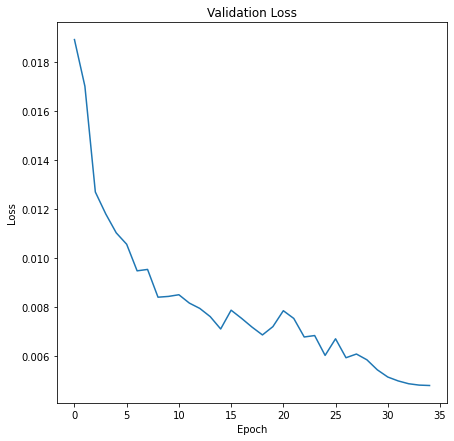

In [7]:
plot_graph(test_losses, "Loss")

## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

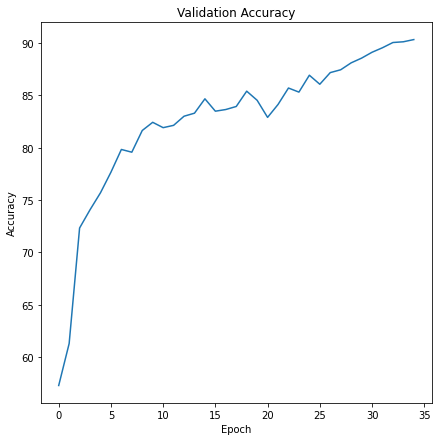

In [8]:
plot_graph(test_accs, "Accuracy")

## Correct Predicted Images

Display 25 correctly classified test images

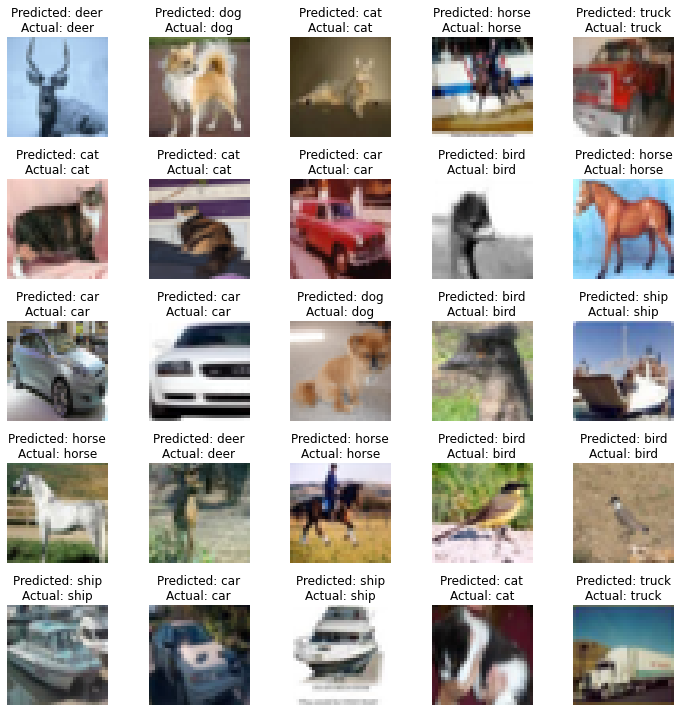

In [9]:
plot_images(correct_imgs, data.classes, "correct_imgs.png")

## Misclassified Images

Display 25 misclassified test images

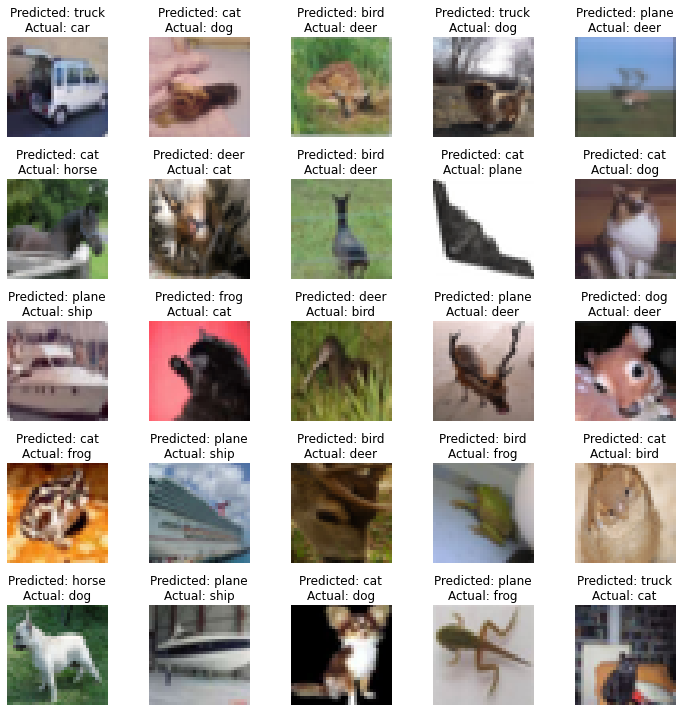

In [10]:
plot_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

## Visualize GradCam

Use GradCam to understand where the network is looking at while prediction

In [0]:
target_layers = ["x3_block","x5_block","x7_block","x11_block"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCam for correctly classified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

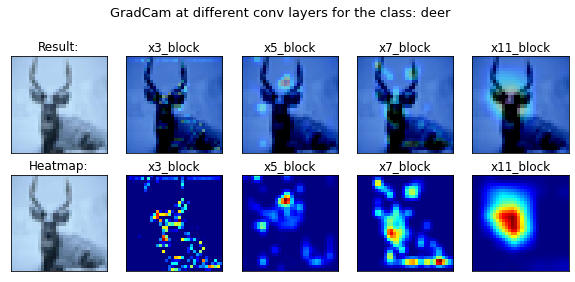

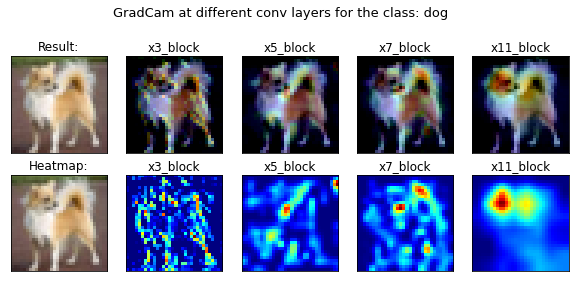

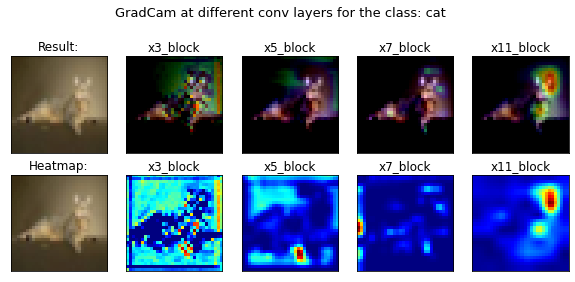

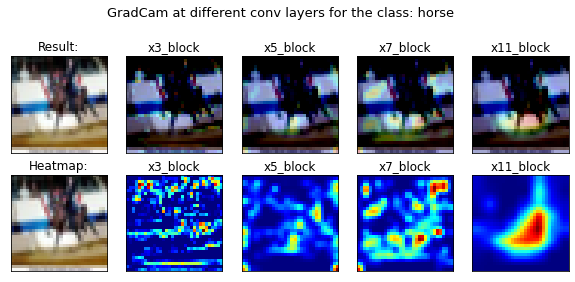

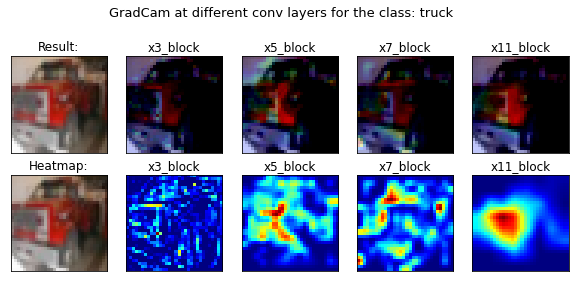

In [12]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

### GradCam for incorrectly classified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

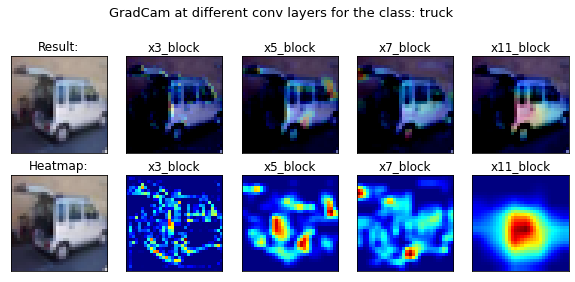

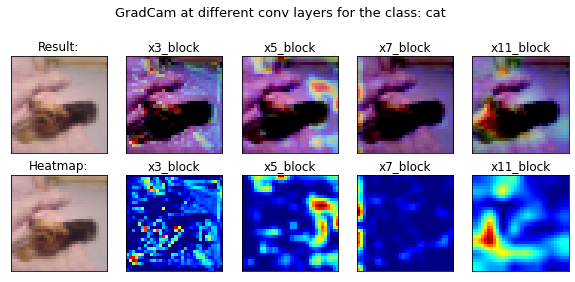

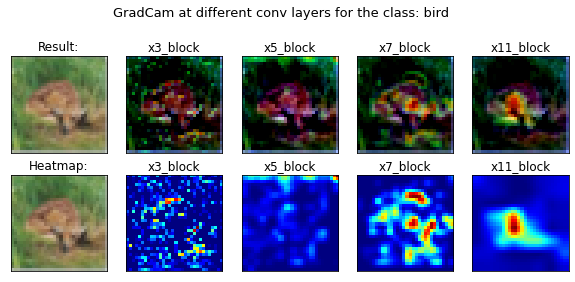

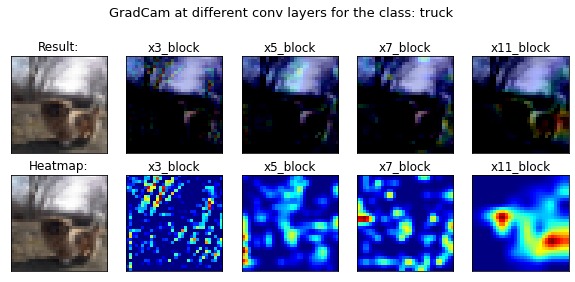

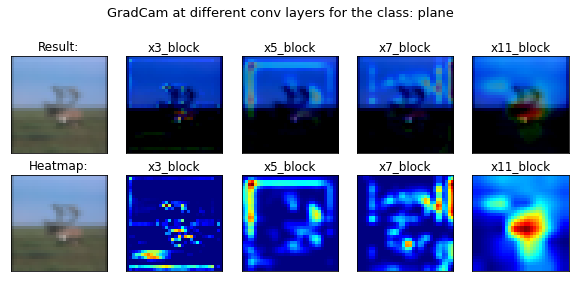

In [13]:
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")